# Example: quadratic line fitting (5)

A fifth simple example of how to use the calibration code to calibrate both measurement mean and measurement error.

In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pk
import subprocess
import shlex
import tempfile

In [2]:
# special imports
from utils import *

In [3]:
# pyplot settings
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["axes.titleweight"] = "bold"

## 1. Setup

In [4]:
# the model to fit
def f(x, a=-2, b=0, c=2):
    return a*(x - b)**2 + c

In [5]:
# lower and upper bounds for the parameters
a_low = -3; a_upp = -1
b_low = -0.1; b_upp = 0.1
c_low = 1; c_upp = 3

In [6]:
# generate a data set
xdata = np.arange(start=0, stop=2.5, step=0.5)
ydata = np.array([f(x) for x in xdata])
sdata = np.array([1/2 - f(x)/6 for x in xdata])

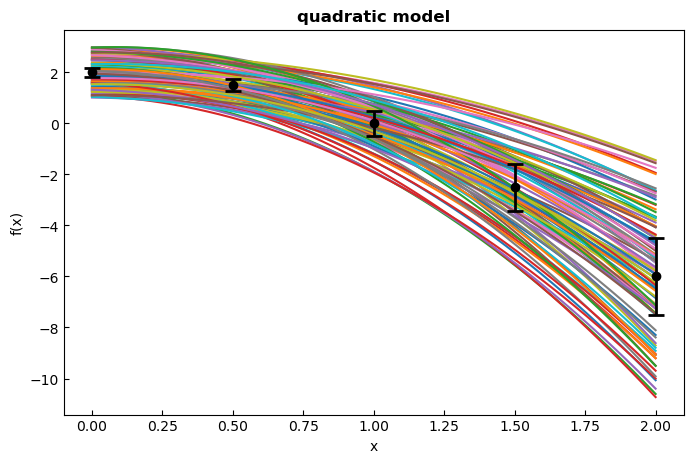

In [7]:
# plot model evaluations and data
x = np.linspace(0, 2)
n = 100
_, ax = plt.subplots(figsize=(8, 5))
for _ in range(n):
    a = (a_upp - a_low)*np.random.rand() + a_low
    b = (b_upp - b_low)*np.random.rand() + b_low
    c = (c_upp - c_low)*np.random.rand() + c_low
    ax.plot(x, f(x, a=a, b=b, c=c))
ax.errorbar(xdata, ydata, yerr=sdata, color="black", linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("quadratic model")
if save:
    plt.savefig(os.path.join(save_location, "example_1_quadratic.png"))
plt.show()

## 2. Surrogate construction

In [8]:
# generate data
n = 100
xs = []
ys = []
for _ in range(n):
    a = (a_upp - a_low)*np.random.rand() + a_low
    b = (b_upp - b_low)*np.random.rand() + b_low
    c = (c_upp - c_low)*np.random.rand() + c_low
    xs.append([a, b, c])
    ys.append(f(xdata, a=a, b=b, c=c))
xs = np.vstack(xs)
ys = np.vstack(ys)

In [9]:
# construct surrogate models
with tempfile.TemporaryDirectory() as tmp:

    # save input and output data
    np.savetxt(os.path.join(tmp, "ptrain.dat"), xs)
    np.savetxt(os.path.join(tmp, "qtrain.dat"), xs)
    np.savetxt(os.path.join(tmp, "ytrain.dat"), ys)

    # save parameter ranges
    np.savetxt(os.path.join(tmp, "param_ranges.dat"), np.array([[a_low, a_upp], [b_low, b_upp], [c_low, c_upp]]))

    # run wibcs
    subprocess.run(shlex.split(f"{path_to_python} {path_to_uq_pc} -r offline_post -p param_ranges.dat -m lsq -n {xs.shape[0]} -s rand -t 2 -z"), cwd=tmp, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # load results
    with open(os.path.join(tmp, "results.pk"), "rb") as file:
        results = pk.load(file)

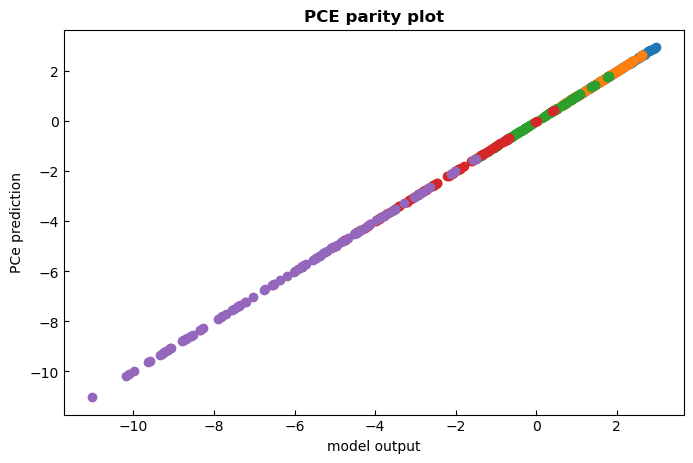

In [10]:
# plot PCE accuracy
_, ax = plt.subplots(figsize=(8, 5))
for i in range(len(results)):
    ytrain = results["training"][2][:, i]
    ytrain_pce = results["training"][3][:, i]
    ax.scatter(ytrain, ytrain_pce)
ax.set_xlabel("model output")
ax.set_ylabel("PCe prediction")
ax.set_title("PCE parity plot")
if save:
    plt.savefig(os.path.join(save_location, "example_1_parity.png"))
plt.show()

## 3. Calibration

In [11]:
# define a range of betas
beta_range = np.linspace(start=1, stop=3, num=11)

In [12]:
# perform calibration for each beta value
l2_errors = []
pushforwards = []
for idx, beta in enumerate(beta_range):
    with tempfile.TemporaryDirectory() as tmp:

        # save data mean and error bars
        np.savetxt(os.path.join(tmp, "data.dat"), np.vstack([ydata, sdata]).T)

        # save PCE coefficients and multi-indices
        for j in range(len(results)):
            np.savetxt(os.path.join(tmp, f"pccf.{j + 1}.dat"), results["pcmi"][0][j])
            np.savetxt(os.path.join(tmp, f"mindex.{j + 1}.dat"), results["pcmi"][1][j], fmt="%d")

        # save prior
        with open(os.path.join(tmp, "prior.dat"), "w") as f:
            f.write(f"gaussian {(a_low + a_upp)/2} {(a_upp - a_low)/2}\n")
            f.write(f"gaussian {(b_low + b_upp)/2} {(b_upp - b_low)/2}\n")
            f.write(f"gaussian {(c_low + c_upp)/2} {(c_upp - c_low)/2}\n")
        
        # run calibration
        subprocess.run(shlex.split(path_to_dfi + " -d data.dat -c pccf.{n}.dat -i mindex.{n}.dat -v pccf.{n}.dat -w mindex.{n}.dat -g 0.1 -k 100 -z -m 0.2 -e 5 -n 200000" + f" -b {beta}"), cwd=tmp, stdout=open("log.out", "w"))
        
        # read standard deviations of pushforward posterior
        with open("log.out", "r") as file:
            lines = file.readlines()
            for line_number, line in enumerate(lines):
                if "Standard deviations" in line:
                    pushforward_std = np.array([float(lines[x].split()[-1]) for x in range(line_number + 2, line_number + 2 + len(results))])
                    break
        l2_errors.append(np.linalg.norm(pushforward_std - sdata))

        # read pushforwards
        pushforward = []
        n = 1
        pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
        while os.path.isfile(pushforward_file):
            pushforward.append(np.loadtxt(pushforward_file))
            n += 1
            pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
        pushforwards.append(pushforward)

    print(f"completed run {idx + 1}/{len(beta_range)} (l2 error = {l2_errors[idx]:.3e})")

completed run 1/11 (l2 error = 5.864e-01)
completed run 2/11 (l2 error = 5.027e-01)
completed run 3/11 (l2 error = 4.047e-01)
completed run 4/11 (l2 error = 3.583e-01)
completed run 5/11 (l2 error = 2.566e-01)
completed run 6/11 (l2 error = 2.047e-01)
completed run 7/11 (l2 error = 1.662e-01)
completed run 8/11 (l2 error = 1.422e-01)
completed run 9/11 (l2 error = 1.601e-01)
completed run 10/11 (l2 error = 1.775e-01)
completed run 11/11 (l2 error = 2.352e-01)


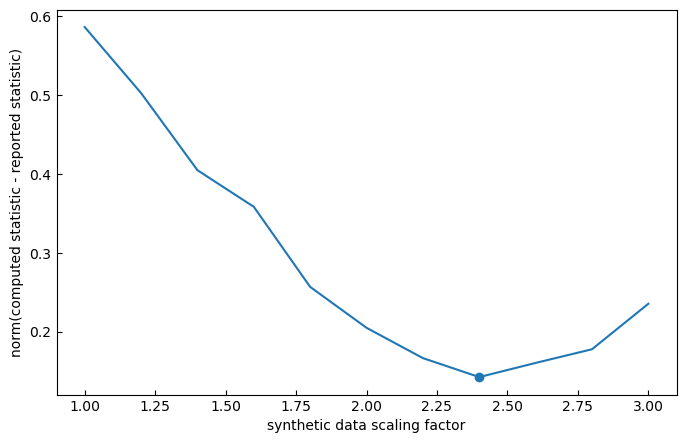

In [13]:
# plot the l2 norm of the difference in standard deviation
_, ax = plt.subplots(figsize=(8, 5))
ax.plot(beta_range, l2_errors)
idx_min = np.argmin(l2_errors)
plt.scatter(beta_range[idx_min], l2_errors[idx_min])
ax.set_xlabel("synthetic data scaling factor")
ax.set_ylabel("norm(computed statistic - reported statistic)")
if save:
    plt.savefig(os.path.join(save_location, "example_5_l2_error.png"))
plt.show()

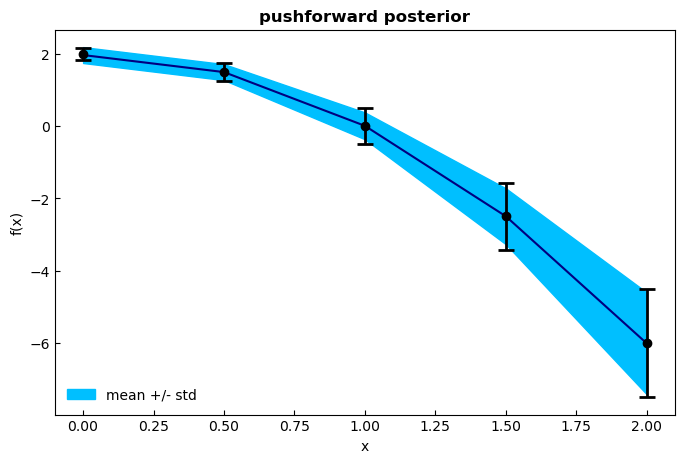

In [14]:
# plot the pushforward posterior
_, ax = plt.subplots(figsize=(8, 5))
pushforward = np.vstack(pushforwards[idx_min])
m = np.mean(pushforward, axis=1)
s = np.std(pushforward, axis=1)
ax.fill_between(xdata, m - s, m + s, color="deepskyblue", label="mean +/- std")
ax.plot(xdata, m, color="navy")
ax.errorbar(xdata, ydata, yerr=sdata, color="black", linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100)
ax.legend(loc="lower left", frameon=False)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("pushforward posterior")
if save:
    plt.savefig(os.path.join(save_location, "example_5_pushforward_posterior.png"))
plt.show()